In [2]:
%pylab inline
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
data = []
datapath = '/home/bigdatas16/1101.csv'
data = pd.read_csv(datapath)
def MA(data,day):
    dataList = range(data['Date'].size)
    tmpList = []
    for i in dataList:
        if i - day + 1 >= 0:
            # 移動平均數 = 採樣天數的股價合計 / 採樣天數
            tmp = data['Close'][i-day+1:i+1].mean()
            tmpList.append(tmp)
        elif i - day + 1 < 0:
            tmp = 0
            tmpList.append(tmp)
    tmpSeries = pd.Series(tmpList)
    data['MA'+str(day)]=tmpSeries
# 乖離率(BIAS)
def BIAS_lag(data,day):
    dataList = range(data['Date'].size)
    tmpList = []
    tmpList.append(0)
    for item in dataList:
        if item-day+1 >= 0:
            tmp = (data['Close'][item]-data['MA'+str(day)][item])/(data['MA'+str(day)][item])*100
            tmpList.append(tmp)
        elif item - day + 1 < 0:
            tmp = 0
            tmpList.append(tmp)         
    tmpSeries = pd.Series(tmpList)
    data['BIAS'+str(day)] = tmpSeries
for i in range(24):
    MA(data,1+i)
    BIAS_lag(data,1+i)
data = data.drop(data.index[4620])
def UP_DOWN(data):
    data_day_number = range(data['Date'].size)
    tmpList = []
    
    for item in data_day_number:
        spread = data['Close'][item] - data['Open'][item]
        if spread > 0 :
            tmp = 1
        elif spread <= 0:
            tmp = 0
 
        tmpList.append(tmp)
    
    tmpSeries = pd.Series(tmpList)
    data['UP_DOWN']=tmpSeries
UP_DOWN(data)
data1 = data.drop(['Date', 'Open', 'High','Low','Close','Volume_n','Volume_m','return','PE','MA1','MA2','MA3','MA4','MA5','MA6','MA7','MA8','MA9','MA10','MA11','MA12','MA13','MA14','MA15','MA16','MA17','MA18','MA19','MA20','MA21','MA22','MA23','MA24'], axis=1)
data1 = data1.fillna(-1)
cols = data1.columns.tolist()
cols[24]
data1 = data1[[cols[24]] + cols[0:23]]
n = len(data['Date'])/5
m = len(data['Date']) - n
train_data = data1.iloc[:m,:]

Populating the interactive namespace from numpy and matplotlib


In [9]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    #tick_marks = np.arange(len(iris.target_names))
    #plt.xticks(tick_marks, iris.target_names, rotation=45)
    #plt.yticks(tick_marks, iris.target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

hyperparametr tuning cross validation 5 folds

In [3]:
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
import time 
sql_sc = SQLContext(sc)
train_data.iloc[:(m/5),:]
train_data.iloc[(m/5):(2*m/5),:]
train_data.iloc[(2*m/5):(3*m/5),:]
train_data.iloc[(3*m/5):(5*m/5),:]
train_data.iloc[(4*m/5):m,:]

cross_data_list = [i for i in range(1,6)]
cross_data_list[0] = train_data.iloc[:(m/5),:]
cross_data_list[1] = train_data.iloc[(m/5):(2*m/5),:]
cross_data_list[2] = train_data.iloc[(2*m/5):(3*m/5),:]
cross_data_list[3] = train_data.iloc[(3*m/5):(5*m/5),:]
cross_data_list[4] = train_data.iloc[(4*m/5):m,:]
cross_data_pandas = [i for i in range(1,6)]
for i in range(0,5,1):
    cross_data_pandas[i] = pd.DataFrame(cross_data_list[i])
#cross_data_pandas[4]

cross_sql = [i for i in range(1,6)]
for i in range(0,5,1):
    cross_sql[i] = sql_sc.createDataFrame(cross_data_pandas[i])


assembler1 = VectorAssembler(inputCols=["BIAS1", "BIAS2", "BIAS3","BIAS4","BIAS5","BIAS6"
                                       ,"BIAS7","BIAS8","BIAS9","BIAS10","BIAS11","BIAS12"
                                       ,"BIAS13","BIAS14","BIAS15","BIAS16","BIAS17","BIAS18"
                                       ,"BIAS19","BIAS20","BIAS21","BIAS22","BIAS23"],outputCol="features")
for i in range(0,5,1):
    cross_sql[i] = assembler1.transform(cross_sql[i])
    
frames = [i for i in range(1,6)]
for i in range(0,5):
    #print(i)
    frames[i] = pd.concat([cross_data_pandas[(i+1)%5],cross_data_pandas[(i+2)%5],cross_data_pandas[(i+3)%5],cross_data_pandas[(i+4)%5]])
    result_sql = [i for i in range(1,6)]

for i in range(0,5):   
    result_sql[i] = sql_sc.createDataFrame(frames[i])   
    
assembler1 = VectorAssembler(inputCols=["BIAS1", "BIAS2", "BIAS3","BIAS4","BIAS5","BIAS6"
                                       ,"BIAS7","BIAS8","BIAS9","BIAS10","BIAS11","BIAS12"
                                       ,"BIAS13","BIAS14","BIAS15","BIAS16","BIAS17","BIAS18"
                                       ,"BIAS19","BIAS20","BIAS21","BIAS22","BIAS23"],outputCol="features")
for i in range(0,5):  
    result_sql[i] = assembler1.transform(result_sql[i])

start = time.time()

cv5_test_error = []    
numTrees_maxDepth = []    
for j in range(1,7,1):
    for k in range(1,21,1):
        Test_Error = []
        for i in range(0,5):
            labelIndexer = StringIndexer(inputCol = "UP_DOWN", outputCol="indexedLabel").fit(result_sql[i])
            featureIndexer = VectorIndexer(inputCol = "features", outputCol="indexedFeatures").fit(result_sql[i])
            #rf = RandomForestClassifier(labelCol="labelIndexer", featuresCol="features")
            rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures",numTrees = k,maxDepth = j)
            # Chain indexers and forest in a Pipeline
            pipeline = Pipeline(stages=[labelIndexer,featureIndexer,rf])
            model = pipeline.fit(result_sql[i])
            predictions = model.transform(cross_sql[i])
            evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction")#, metricName="accuracy")
            accuracy = evaluator.evaluate(predictions)
            print("Test Error(%d) = %g" % (i,1.0 - accuracy))
            Test_Error.append(1.0 - accuracy)
        cv5_test_error.append(mean(Test_Error))
        numTrees_maxDepth.append([i,j])

end = time.time()
print "Cross Validation 5 Folds Hyperparameter Tuning : Time taken = %f second"%(end - start)
        
mintest = np.min(cv5_test_error)
c = []
for i in range(len(cv5_test_error)):
    c.append(np.min(cv5_test_error) == cv5_test_error[i])
    
for i in range(len(cv5_test_error)):    
    if c[i] == True:
        print(numTrees_maxDepth[i],mintest)       

Test Error(0) = 0.440171
Test Error(1) = 0.434464
Test Error(2) = 0.553956
Test Error(3) = 0.541756
Test Error(4) = 0.551323
Test Error(0) = 0.478178
Test Error(1) = 0.441838
Test Error(2) = 0.554643
Test Error(3) = 0.539621
Test Error(4) = 0.554313
Test Error(0) = 0.440973
Test Error(1) = 0.441837
Test Error(2) = 0.553956
Test Error(3) = 0.570785
Test Error(4) = 0.551992
Test Error(0) = 0.442912
Test Error(1) = 0.440042
Test Error(2) = 0.553956
Test Error(3) = 0.541756
Test Error(4) = 0.554974
Test Error(0) = 0.442912
Test Error(1) = 0.444319
Test Error(2) = 0.55103
Test Error(3) = 0.539621
Test Error(4) = 0.551323
Test Error(0) = 0.440529
Test Error(1) = 0.519021
Test Error(2) = 0.553956
Test Error(3) = 0.539621
Test Error(4) = 0.551323
Test Error(0) = 0.442912
Test Error(1) = 0.519021
Test Error(2) = 0.553956
Test Error(3) = 0.541756
Test Error(4) = 0.551323
Test Error(0) = 0.440973
Test Error(1) = 0.44094
Test Error(2) = 0.553956
Test Error(3) = 0.541387
Test Error(4) = 0.554313
Te

predict

In [5]:
train_data = data1.iloc[:m,:]
train_sql = sql_sc.createDataFrame(train_data)
test_data = data1.iloc[m:,:]
test_sql = sql_sc.createDataFrame(test_data)

assembler1 = VectorAssembler(inputCols=["BIAS1", "BIAS2", "BIAS3","BIAS4","BIAS5","BIAS6"
                                        ,"BIAS7","BIAS8","BIAS9","BIAS10","BIAS11","BIAS12"
                                        ,"BIAS13","BIAS14","BIAS15","BIAS16","BIAS17","BIAS18"
                                        ,"BIAS19","BIAS20","BIAS21","BIAS22","BIAS23"],outputCol="features")
train_sql = assembler1.transform(train_sql)
labelIndexer = StringIndexer(inputCol = "UP_DOWN", outputCol="indexedLabel").fit(train_sql)
featureIndexer = VectorIndexer(inputCol = "features", outputCol="indexedFeatures").fit(train_sql)
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures",numTrees = 4,maxDepth = 6)
pipeline = Pipeline(stages=[labelIndexer,featureIndexer,rf])
model = pipeline.fit(train_sql)
assembler = VectorAssembler(inputCols=["BIAS1", "BIAS2", "BIAS3","BIAS4","BIAS5","BIAS6"
                                        ,"BIAS7","BIAS8","BIAS9","BIAS10","BIAS11","BIAS12"
                                        ,"BIAS13","BIAS14","BIAS15","BIAS16","BIAS17","BIAS18"
                                        ,"BIAS19","BIAS20","BIAS21","BIAS22","BIAS23"],outputCol="features")
test_sql = assembler.transform(test_sql)
predictions = model.transform(test_sql)

0.3963565348028794

In [10]:
prediction_1101 = predictions.select("prediction", "indexedLabel")
prediction_1101_pandas = prediction_1101.toPandas()
cm = confusion_matrix(prediction_1101_pandas['indexedLabel'], prediction_1101_pandas['prediction'])
pd.crosstab(prediction_1101_pandas['indexedLabel'], prediction_1101_pandas['prediction'], rownames=['actual'], colnames=['preds'])

preds,0.0,1.0
actual,,
0.0,494,13
1.0,411,6


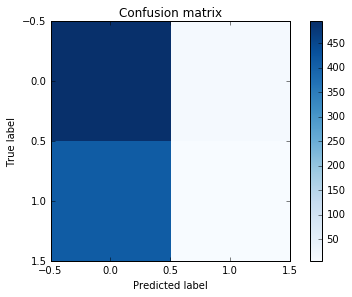

In [11]:
plot_confusion_matrix(cm)
plt.show()

In [12]:
data_p = data[['Close','Open']][(4621-n):4622].values

In [14]:
data_p1 = pd.DataFrame(data_p,columns = ['Close','Open'])

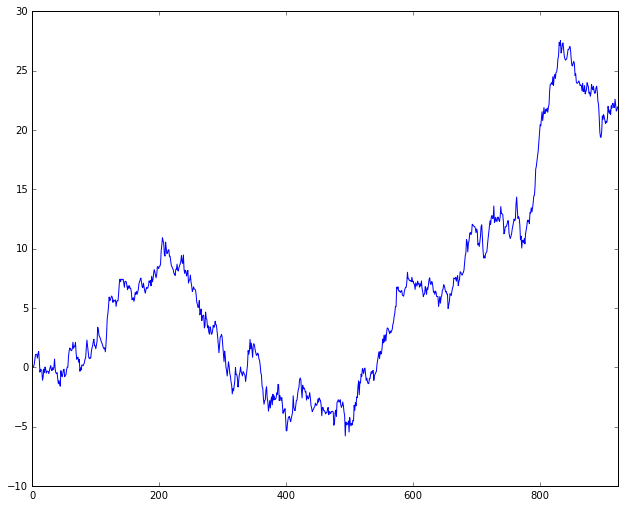

In [27]:
result = np.c_[prediction_1101_pandas['indexedLabel'],prediction_1101_pandas['prediction']]
result1 = pd.DataFrame(result , columns = ['test', 'prediction'])
result2 = pd.concat([data_p1, result1], axis=1)
result2["Cl - Op"] = result2['Close'] - result2['Open']
result2['prediction'] = result2['prediction'].replace(0,-1)
result2['profit'] = result2['Cl - Op'] * result2['prediction']
a = result2['profit'].cumsum()
from IPython.core.pylabtools import figsize
figsize(10.5, 8.5)
a.plot()

In [50]:
result2['processing fee1'] = np.where(result2['prediction'] == 1,(result2['Close']*(4.425/1000.0) + result2['Open']*(1.425/1000.0))*1
                                      ,(result2['Close']*(1.425/1000.0) + result2['Open']*(4.425/1000.0)))
result2['profit_r_fee'] = result2['profit'] -  result2['processing fee1']

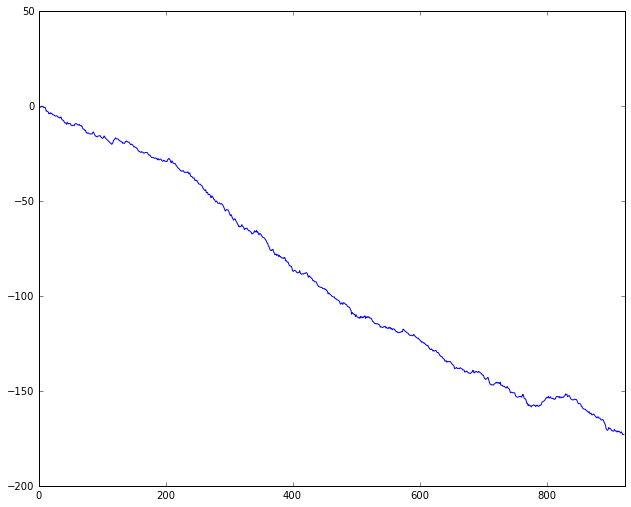

In [51]:
b = result2['profit_r_fee'].cumsum()
from IPython.core.pylabtools import figsize
figsize(10.5, 8.5)
b.plot()

In [52]:
result2['profit2'] = 0.0
#len(result2)
result2['profit2'][1]

0.0

In [53]:
result2.head()

,Close,Open,test,prediction,Cl - Op,profit,processing fee1,profit_r_fee,profit2
0,28.76,28.67,1.0,-1.0,0.09,-0.09,0.167848,-0.257848,0.0
1,28.67,28.76,1.0,-1.0,-0.09,0.09,0.168118,-0.078118,0.0
2,28.63,28.67,0.0,-1.0,-0.04,0.04,0.167662,-0.127662,0.0
3,28.29,28.50,0.0,-1.0,-0.21,0.21,0.166426,0.043574,0.0
4,27.95,28.33,0.0,-1.0,-0.38,0.38,0.165189,0.214811,0.0


In [58]:
result2['profit2'][0] = 0 #(-1) * result2['Open'][0]

for i in range(0,len(result2)-1,1):
    if result2['prediction'][i+1] == 1 and result2['prediction'][i] == -1:
        result2['profit2'][i+1] = result2['profit2'][i] + (-1) * result2['Open'][i+1]
    elif result2['prediction'][i+1] == 1 and result2['prediction'][i] == 1:
        result2['profit2'][i+1] = result2['profit2'][i] 
    elif result2['prediction'][i+1] == -1 and result2['prediction'][i] == 1:
        result2['profit2'][i+1] = result2['profit2'][i] + result2['Close'][i]
    elif result2['prediction'][i+1] == -1 and result2['prediction'][i] == -1:
        result2['profit2'][i+1] = result2['profit2'][i] 

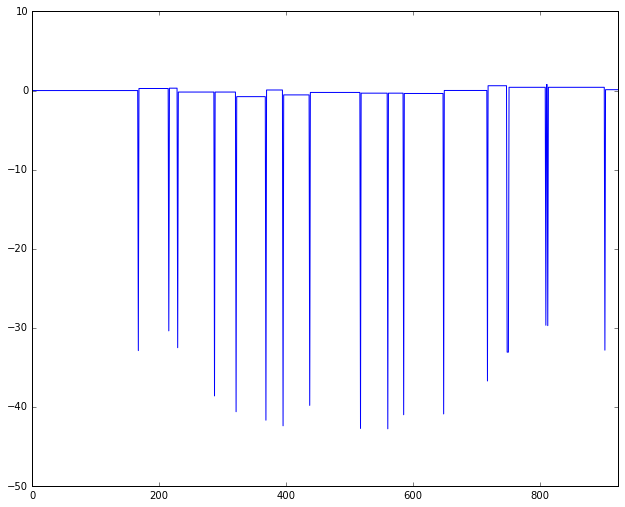

In [63]:
result2['profit2'].plot()

In [64]:
result2['processing_fee_2'] = 0.0

In [83]:
result2['processing_fee_2'][0] = 0#(-1) * result2['Open'][0]

for i in range(0,len(result2)-1,1):
    if result2['prediction'][i+1] == 1 and result2['prediction'][i] == -1:
        result2['processing_fee_2'][i+1] = result2['processing_fee_2'][i] + (-1) * result2['Open'][i+1] - (result2['Open'][i+1])*((1.425/1000.0))
    elif result2['prediction'][i+1] == 1 and result2['prediction'][i] == 1:
        result2['processing_fee_2'][i+1] = result2['processing_fee_2'][i]
    elif result2['prediction'][i+1] == -1 and result2['prediction'][i] == 1:
        result2['processing_fee_2'][i+1] = result2['processing_fee_2'][i] + result2['Open'][i+1] - (result2['Open'][i+1])*(1.425/1000.0)
    elif result2['prediction'][i+1] == -1 and result2['prediction'][i] == -1:
        result2['processing_fee_2'][i+1] = result2['processing_fee_2'][i]

In [84]:
result2

,Close,Open,test,prediction,Cl - Op,profit,processing fee1,profit_r_fee,profit2,processing_fee_2
0,28.76,28.67,1.0,-1.0,0.09,-0.09,0.167848,-0.257848,0.00,0.000000
1,28.67,28.76,1.0,-1.0,-0.09,0.09,0.168118,-0.078118,0.00,0.000000
2,28.63,28.67,0.0,-1.0,-0.04,0.04,0.167662,-0.127662,0.00,0.000000
3,28.29,28.50,0.0,-1.0,-0.21,0.21,0.166426,0.043574,0.00,0.000000
4,27.95,28.33,0.0,-1.0,-0.38,0.38,0.165189,0.214811,0.00,0.000000
5,27.57,28.00,0.0,-1.0,-0.43,0.43,0.163187,0.266813,0.00,0.000000
6,27.53,27.57,0.0,-1.0,-0.04,0.04,0.161227,-0.121228,0.00,0.000000
7,27.53,27.49,0.0,-1.0,0.04,-0.04,0.160874,-0.200874,0.00,0.000000
8,27.95,27.66,1.0,-1.0,0.29,-0.29,0.162224,-0.452224,0.00,0.000000
9,27.53,27.91,1.0,-1.0,-0.38,0.38,0.162732,0.217268,0.00,0.000000


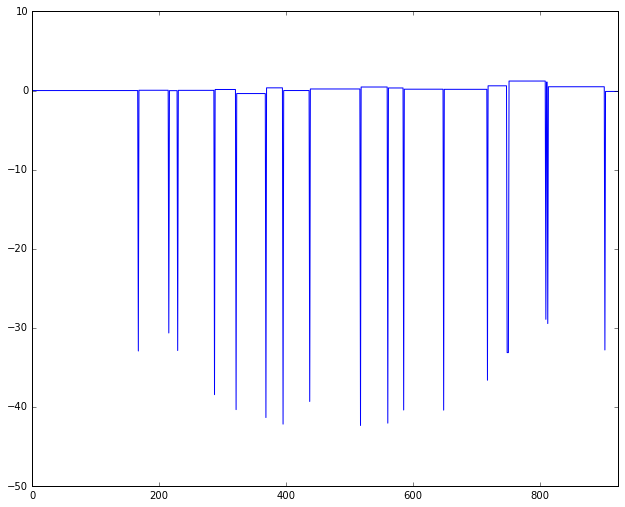

In [85]:
result2['processing_fee_2'].plot()#[1101:2301].plot()